### Naive predictions and Random Forest Baseline

For a baseline model, this notebook implements:
- Naive method of forecasting where it uses the most recent newarrival available
- RandomForest method, simply considering the data basically as cross-sectional data.

In [1]:
import numpy as np
import pandas as pd
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_acf
# from speedy_bois import * 

# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import  HistGradientBoostingRegressor

# from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
# from skforecast.ForecasterAutoreg import ForecasterAutoreg
# from skforecast.model_selection import backtesting_forecaster
# from skforecast.model_selection import grid_search_forecaster
# from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
# from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

In [2]:
data = pd.read_csv('../../data/data.csv', engine='pyarrow').drop_duplicates(subset=['Id','year']).drop(['Country_o','Country_d','iso_d','iso_o', ''], axis=1)

#### Preprocessing

In [3]:
# filter out missing data
data = data[data.year < 2022]

# all observations must have at least one value greater than c
c = 100
data = data.groupby('Id', as_index=False).filter(lambda x: x['newarrival'].max() > c)

data['year'] = pd.to_datetime(data['year'], format='%Y')
data = data.set_index(['year', 'Id'])
data.index.levels[1].freq = "Y"
#data = data['y']
data = data.sort_index()

Specify train and test sets:

In [4]:
end_train = '2016-01-01'
end_val = '2016-01-01'

data_train = data.loc[:end_train, :].copy()
# data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:, :].copy()

#### Naive method- Baseline approach

In [5]:
# def filter_multi(df,col,val):
#     col_index = pd.Series(data.index.names)[(pd.Series(data.index.names) == col)].index.tolist()[0]
#     return np.in1d(df.index.get_level_values(col_index), [val])

In [6]:
# naive prediction
def naive_prediction(series, h):
    last_val = series.iloc[-1]
    pred =  np.repeat(last_val, h)
    return pred

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

# rolling window predictions
def rolling_rmse(series, window_len, h):
    series_len = len(series)
    n_of_forecasts = (series_len - (window_len + h) + 1)

    if n_of_forecasts < 1:
        raise ValueError
    
    errors = np.array([])
    errors.shape = (0, 3)

    for i in range(n_of_forecasts):
        window = series.iloc[i:(i + window_len)]
        forecast = naive_prediction(window, h)
        actual = series[(i + window_len):(i + window_len + h)].values
        
        rmse_error = ((forecast - actual)**2)**.5
        errors = np.vstack([errors, rmse_error])

    return pd.DataFrame(errors, columns = np.array([*range(3)])+1).melt(var_name='horizon',value_name='naive')

In [17]:
# serial
naive_metrics = data_test.newarrival.groupby(level='Id').apply(lambda x:rolling_rmse(x, 1, 3)).groupby('horizon').mean()
naive_metrics

,naive
horizon,
1,1744.203209
2,2238.553066
3,2039.282730


#### Random Forest Baseline

In [9]:
def data_prep(df, h):
    new_cols = []
    for h_i in range(h):
        df[h_i + 1] = df.groupby(level='Id').newarrival.shift(-(h_i + 1))
        new_cols.append((h_i+1))
    
    id_vars = data_train.columns.values[~pd.Series(data_train.columns.values).isin(new_cols)].tolist()
    
    df = df.melt(id_vars = id_vars, var_name = 'horizon', value_name = 'newarrival_h').dropna()
    id_vars.append('horizon')
    X = df[id_vars]
    y = df['newarrival_h']
    return X, y

X_train, y_train = data_prep(data_train, 3)
X_test, y_test = data_prep(data_test, 3)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [19]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, rf.predict(X_test), squared=False)

def compute_rmse(model, X_test, y_test):
    y_test_pred = rf.predict(X_test)
    rmse = ((y_test_pred - y_test)**2)**.5
    return pd.concat([rmse, X_test.horizon], axis=1)

rf_metrics = compute_rmse(rf, X_test, y_test).groupby('horizon').mean().rename({'newarrival_h':'RandomForest'}, axis=1)

The Theil ratio $ (T) $ is as follows:
$$ T = \frac{RMSE_X}{RMSE_{RW}} $$
Where $ X $ is the model under investigation 

<Axes: title={'center': 'Theil Index of Baseline RandomForest Model'}, xlabel='horizon'>

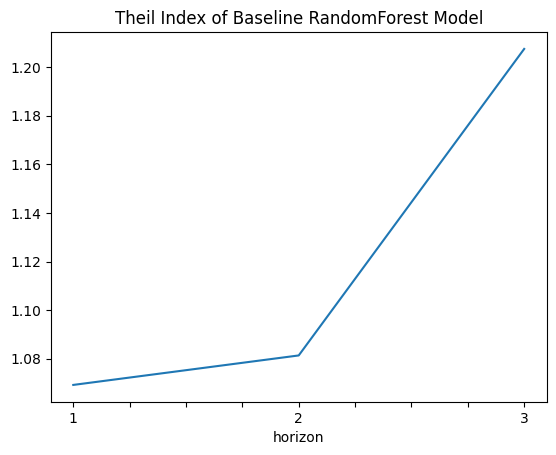

In [30]:
def compute_theil(df, naive_col, model_col):
    theil = df[model_col]/df[naive_col]
    theil.index = theil.index.astype(str)
    return theil

compute_theil(pd.concat([naive_metrics,rf_metrics],axis=1), 'naive','RandomForest').plot(title='Theil Index of Baseline RandomForest Model', x='horizon')